In [1]:
%matplotlib inline
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# REFERENCE: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
data = sm.datasets.co2.load_pandas()
y = data.data

In [2]:
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()
# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

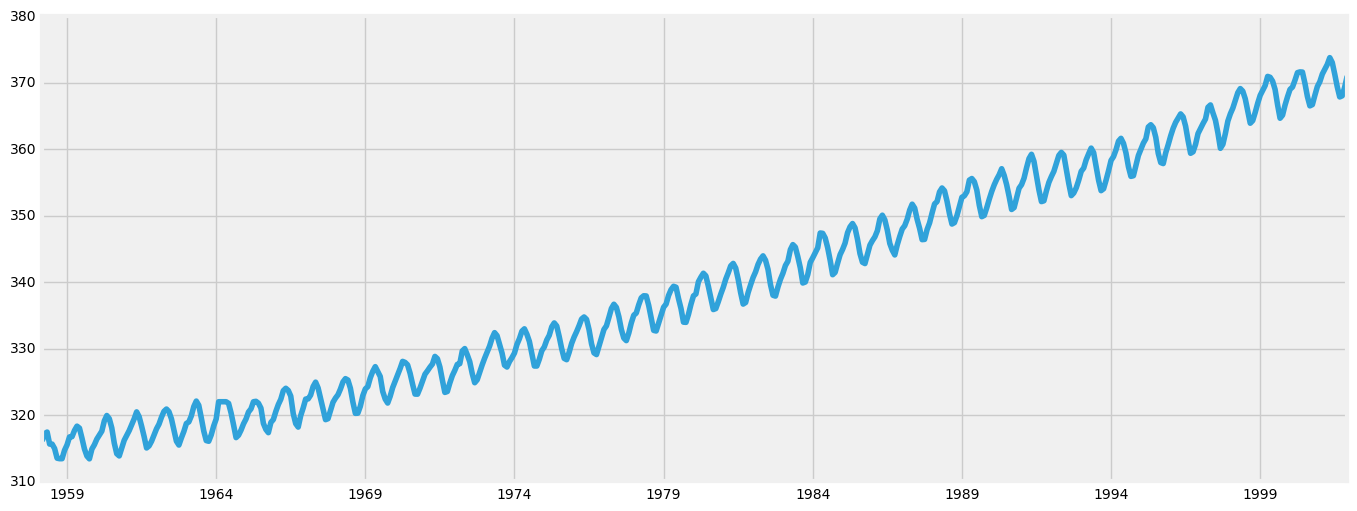

In [3]:
y.plot(figsize=(15, 6))
plt.show()

In [4]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

"""
#https://docs.python.org/2/library/itertools.html
#We can now use the triplets of parameters defined above to automate the process of training 
#and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, 
#this process is known as grid search (or hyperparameter optimization) for model selection.
# http://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111
"""

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


'\n#https://docs.python.org/2/library/itertools.html\n#We can now use the triplets of parameters defined above to automate the process of training \n#and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, \n#this process is known as grid search (or hyperparameter optimization) for model selection.\n# http://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111\n'

In [5]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
"""
#The code chunk below iterates through combinations of parameters and uses the SARIMAX function 
#from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies 
#the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component 
#of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.
"""
aic_results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            aic_results.append([param,param_seasonal,results.aic])
        except Exception as e:
            print(e)
            continue
            
print("done")


Number of states in statespace model must be a positive number.
could not broadcast input array from shape (0,0) into shape (12,12)
could not broadcast input array from shape (0,0) into shape (1,1)
could not broadcast input array from shape (0,0) into shape (13,13)
done


In [7]:
b = np.array(aic_results)
minimums = np.argmin(b, axis=0)
smallest_aic = b[minimums[2]]
smallest_aic

array([(1, 1, 1), (1, 1, 1, 12), 277.78022022351468], dtype=object)

In [8]:
# Fit seasonal ARIMA with parameters corresponding to the lowest AIC
mod = sm.tsa.statespace.SARIMAX(y,
                                order= smallest_aic[0],  #(1, 1, 1),
                                seasonal_order= smallest_aic[1], #(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])
"""
# The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 
# The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower 
# or close to 0.05, so it is reasonable to retain all of them in our model.
"""

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.163      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


'\n# The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. \n# The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower \n# or close to 0.05, so it is reasonable to retain all of them in our model.\n'

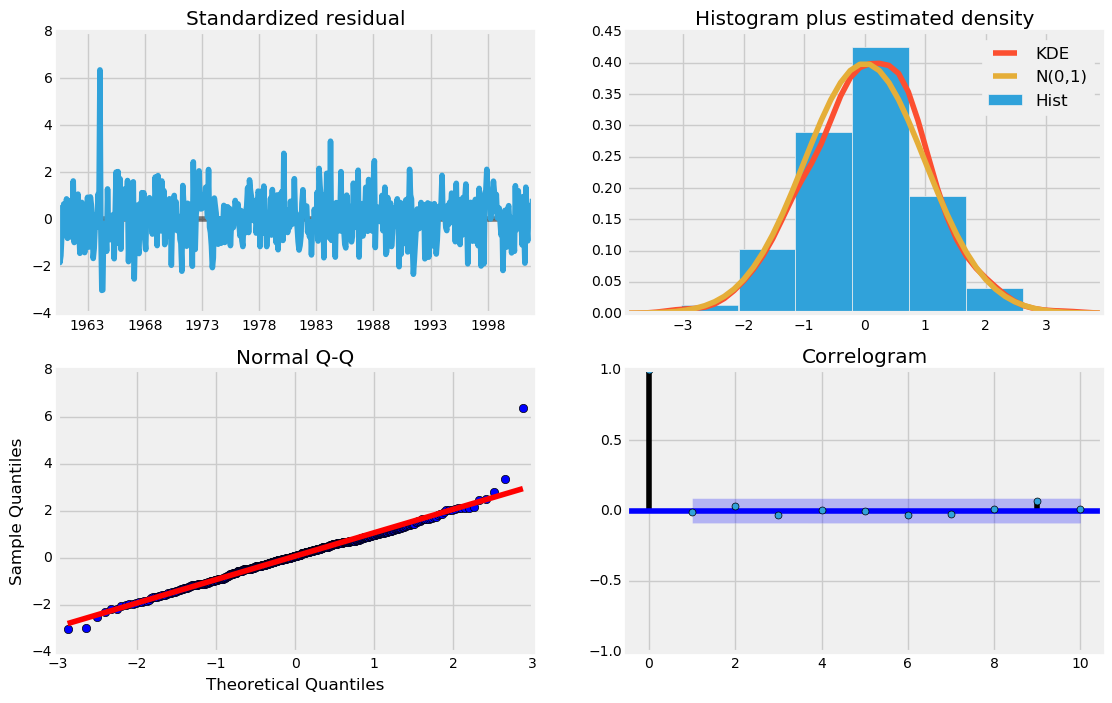

In [9]:
# generate model diagnostics and investigate for any unusual behavior.
"""
# Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed 
# with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that 
# it can be further improved.
"""
results.plot_diagnostics(figsize=(12, 8))
plt.show()

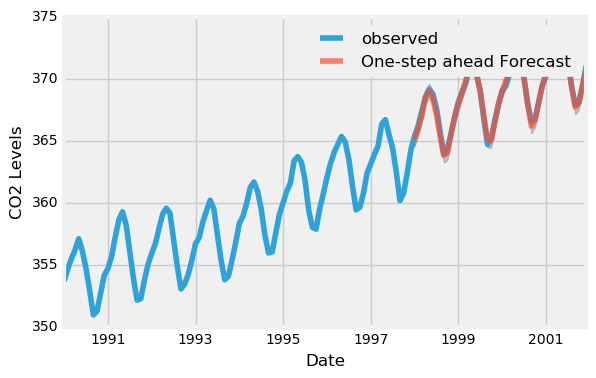

In [10]:
# Forecast and measure accuracy of forecasts (VISUAL ACTUAL VS. PREDICTED)
# The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that 
# forecasts at each point are generated using the full history up to that point.
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.figure(figsize=(15,8))
plt.show()

In [11]:
#  Quantify the accuracy of our forecasts.
# use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. 
# For each predicted value, we compute its distance to the true value and square the result. 
# The results need to be squared so that positive/negative differences do not cancel each other out 
# when we compute the overall mean.
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [12]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

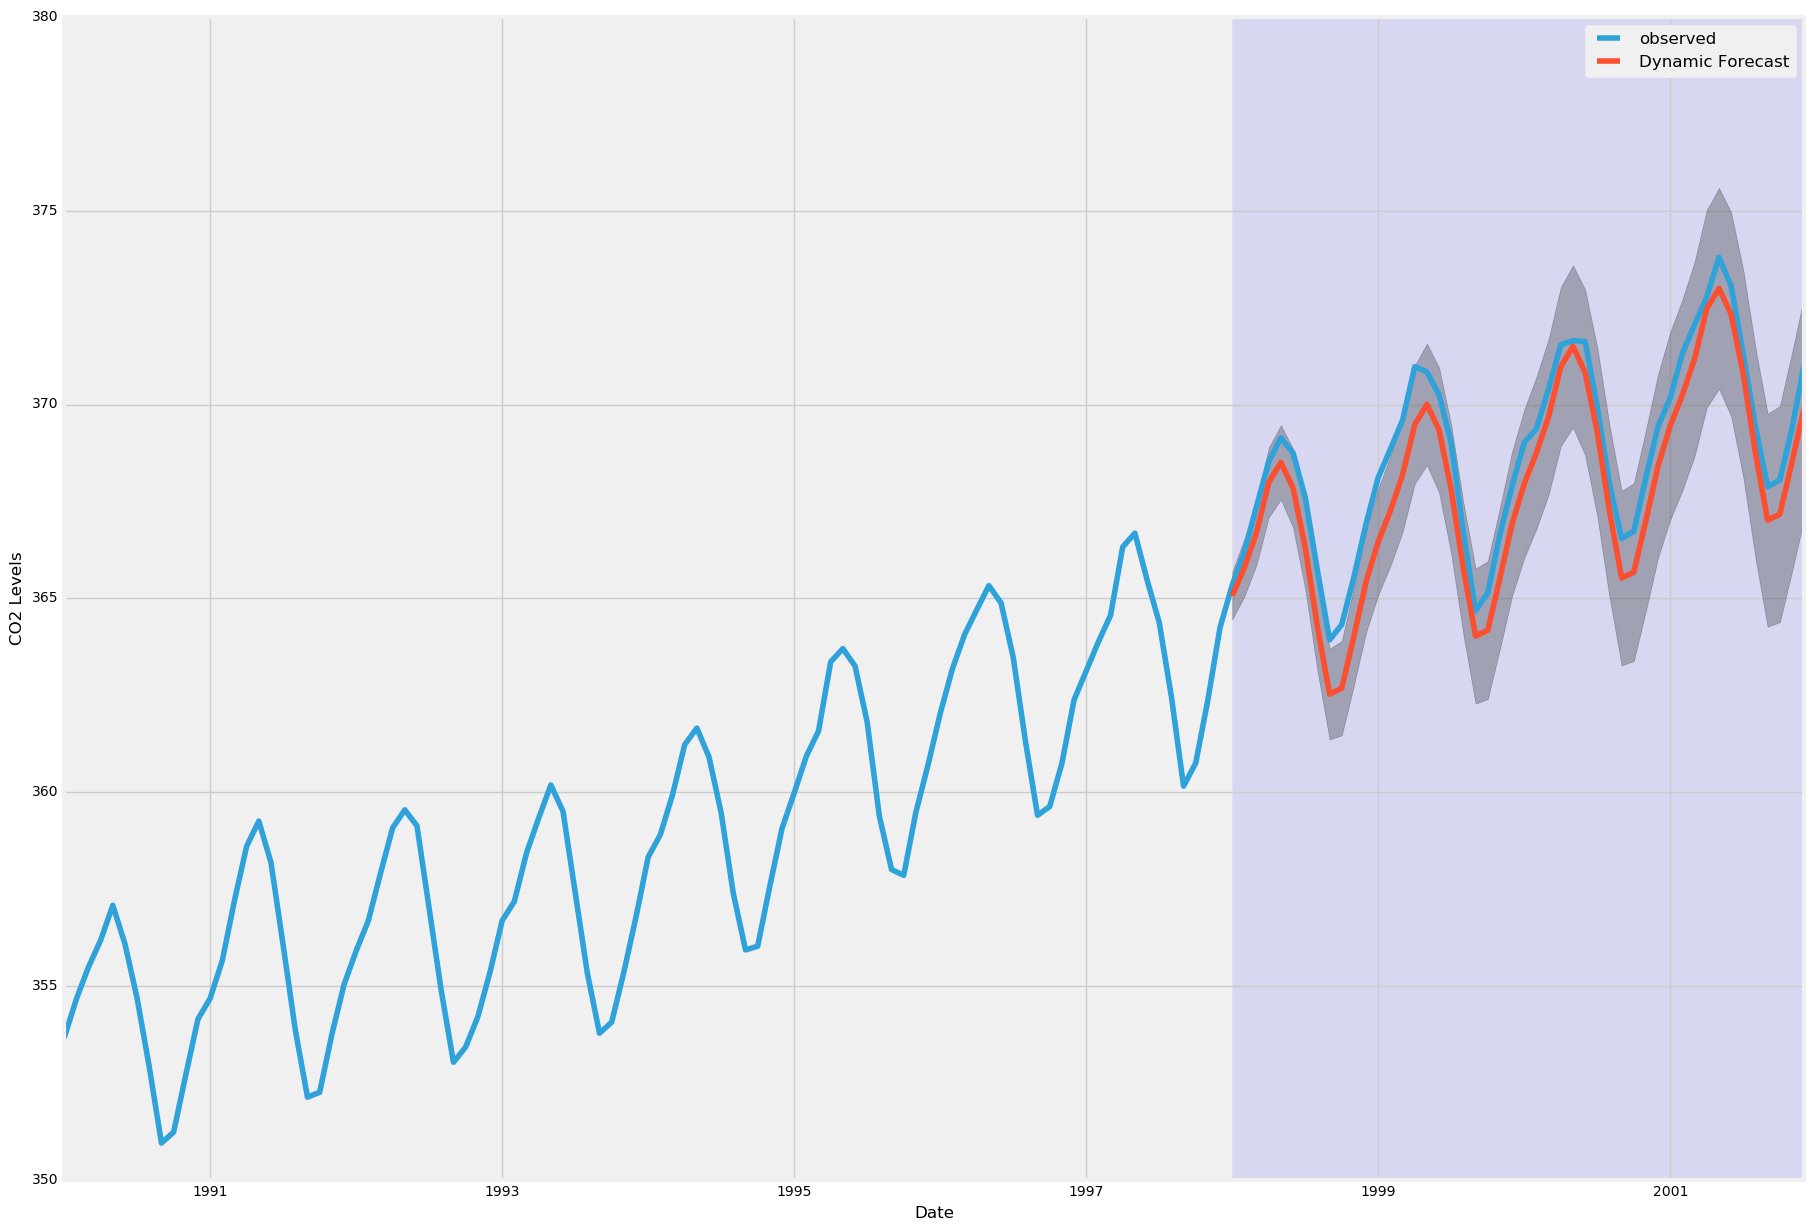

In [13]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [14]:
# Once again, we quantify the predictive performance of our forecasts by computing the MSE:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


In [15]:
# How to forecast future values
# get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

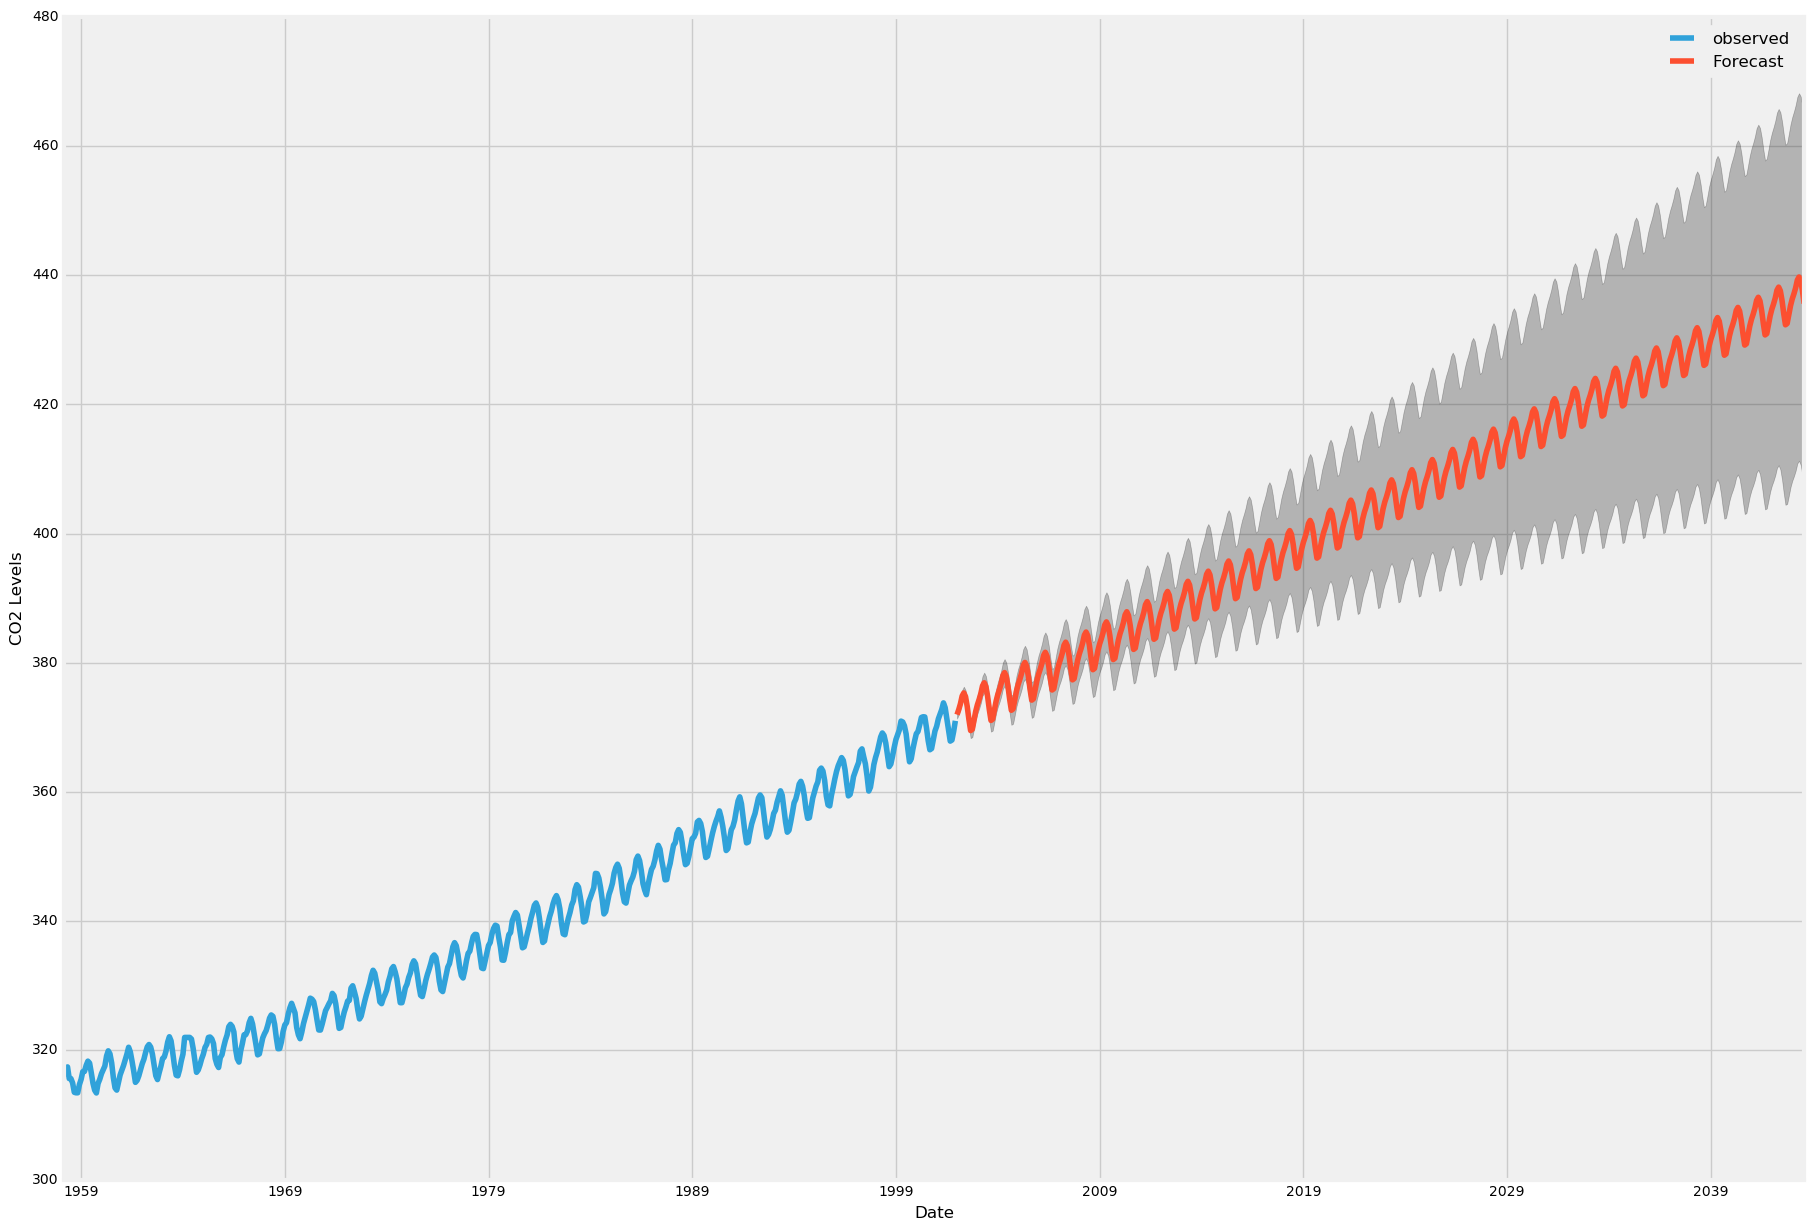

In [19]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()